In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

In [61]:
# Network Parameters
num_input = 2
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [62]:
def read_sensor(filename):
#     print(filename)
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
#     data_x = []
#     data_x.append(np.array(dataset.iloc[:, 1]))
    data_x = np.array(dataset.iloc[:, 1:3])
#     print(data_x.shape)
    return data_x


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    cur_dir = 1
    if(all_foot[0] == 'L'):
        cur_dir = 0
    strike_times.append([0.0, cur_dir])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times.append([length/25.0, 0.5])
#     print(strike_times[0:10])
#     print(len(strike_times))

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])
         
    return window_y

In [63]:
data_x = []
window_y = []
for i in range(1,5):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i61L.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
        
for i in range(1,5):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i62R.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
        
print(len(data_x)) #21843
print(len(window_y))

28492
28492


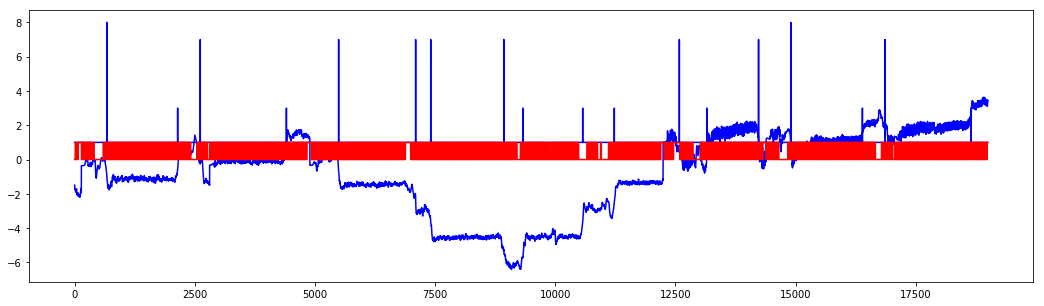

In [65]:
plt.figure(figsize=(18, 5))
start=2000
end=21000
#time back to 0
plt.plot([i[0] for i in data_x[start:end]], 'b')
plt.plot([i[0] for i in window_y[start:end]], 'r')
plt.show()

In [66]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [window_y[i] for i in order]

print(len(train_x))

28492


In [67]:
test_x, test_y=[], []
for i in range(5,7):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i61L.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        test_x.append(x)
        test_y.append(y)
        
for i in range(5,7):
    data_x_part = read_sensor('weallwalk/Azimuth/T'+str(i)+'_ID1_GD-i62R.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        test_x.append(x)
        test_y.append(y)

print(len(test_x))

14233


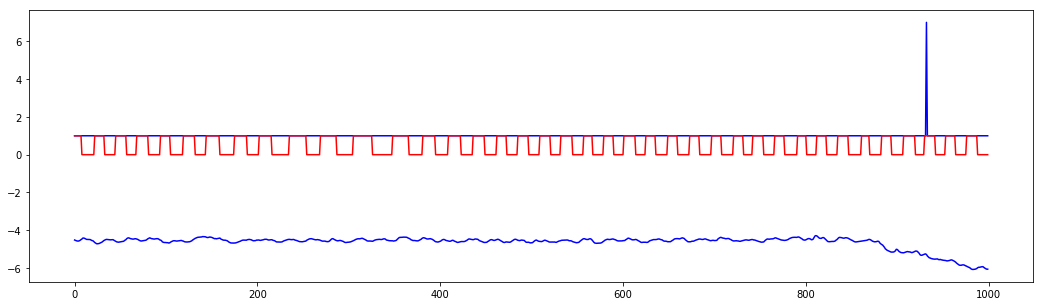

In [68]:
start=10000
end=11000
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x[start:end]], 'b')
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.show()

In [69]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [70]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
train_x.extend(train_x[0:batch_size])
train_y.extend(train_y[0:batch_size])
training_steps = 6001

In [72]:
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-batch-test-add-data.ckpt-10000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            print('Loss at step %d: %f' % (step, l))
        if (step % 2000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-azimuth-12.ckpt', global_step=step)
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

Initialized
Loss at step 0: 1.569146
Loss at step 200: 0.236558
Loss at step 400: 0.181347
Loss at step 600: 0.180619
Loss at step 800: 0.171227
Loss at step 1000: 0.149737
Loss at step 1200: 0.153310
Loss at step 1400: 0.141121
Loss at step 1600: 0.141208
Loss at step 1800: 0.114740
Loss at step 2000: 0.140211
Loss at step 2200: 0.100280
Loss at step 2400: 0.116840
Loss at step 2600: 0.113793
Loss at step 2800: 0.087237
Loss at step 3000: 0.113857
Loss at step 3200: 0.087362
Loss at step 3400: 0.084467
Loss at step 3600: 0.102103
Loss at step 3800: 0.086031
Loss at step 4000: 0.078562
Loss at step 4200: 0.085053
Loss at step 4400: 0.080550
Loss at step 4600: 0.087011
Loss at step 4800: 0.067141
Loss at step 5000: 0.078992
Loss at step 5200: 0.067621
Loss at step 5400: 0.068088
Loss at step 5600: 0.062788
Loss at step 5800: 0.063151
Loss at step 6000: 0.057037


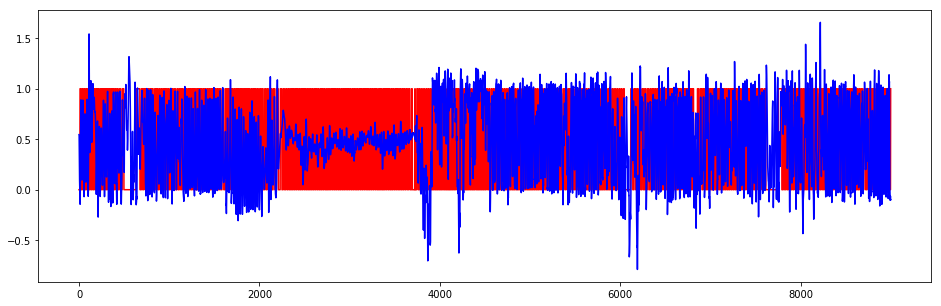

In [73]:
plt.figure(figsize=(16, 5))
start = 1000
end =10000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

In [74]:
print(test_loss)

count = 0
for i in range(0, len(test_x)):
    if(test_y[i][0] == round(test_logits[i][0])):
        count += 1;
print(count/len(test_x))

0.265617
0.636548865313005
